#  <font color=navy> 7-2. Bayesian의 A/B Test와 Loss function

## 7.1 Revisit: 전환율 
-  A, B 중에서 어느 사이트의 전환확률이 높은가?
  
만약 사전확률분포가 $\text{Beta} (\alpha_0, \beta_0)$ 이고 실험 $N$번, 성공 $X$개면 사후확률분포는 $\text{Beta}(\alpha_0 + X, \beta_0 + N - X)$ 이며 `SciPy`의 `beta`함수를 사용하여 사후확률분포에서 바로 표본을 추출할 수  있다.

In [1]:
visitors_to_A = 1300
visitors_to_B = 1275
conversions_from_A = 120
conversions_from_B = 125

In [2]:
from scipy.stats import beta

alpha_prior = 1
beta_prior = 1
posterior_A = beta(alpha_prior + conversions_from_A,
    beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
    beta_prior + visitors_to_B - conversions_from_B)

In [3]:
samples = 20000 # 더 나은 근사를 위해서는 이 값이 더 커야 한다 # We want this to be large to get a better approximation.
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)
print ((samples_posterior_A > samples_posterior_B).mean())

0.3143


In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

matplotlib.rc('font', family='NanumGothic')  # Linux
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


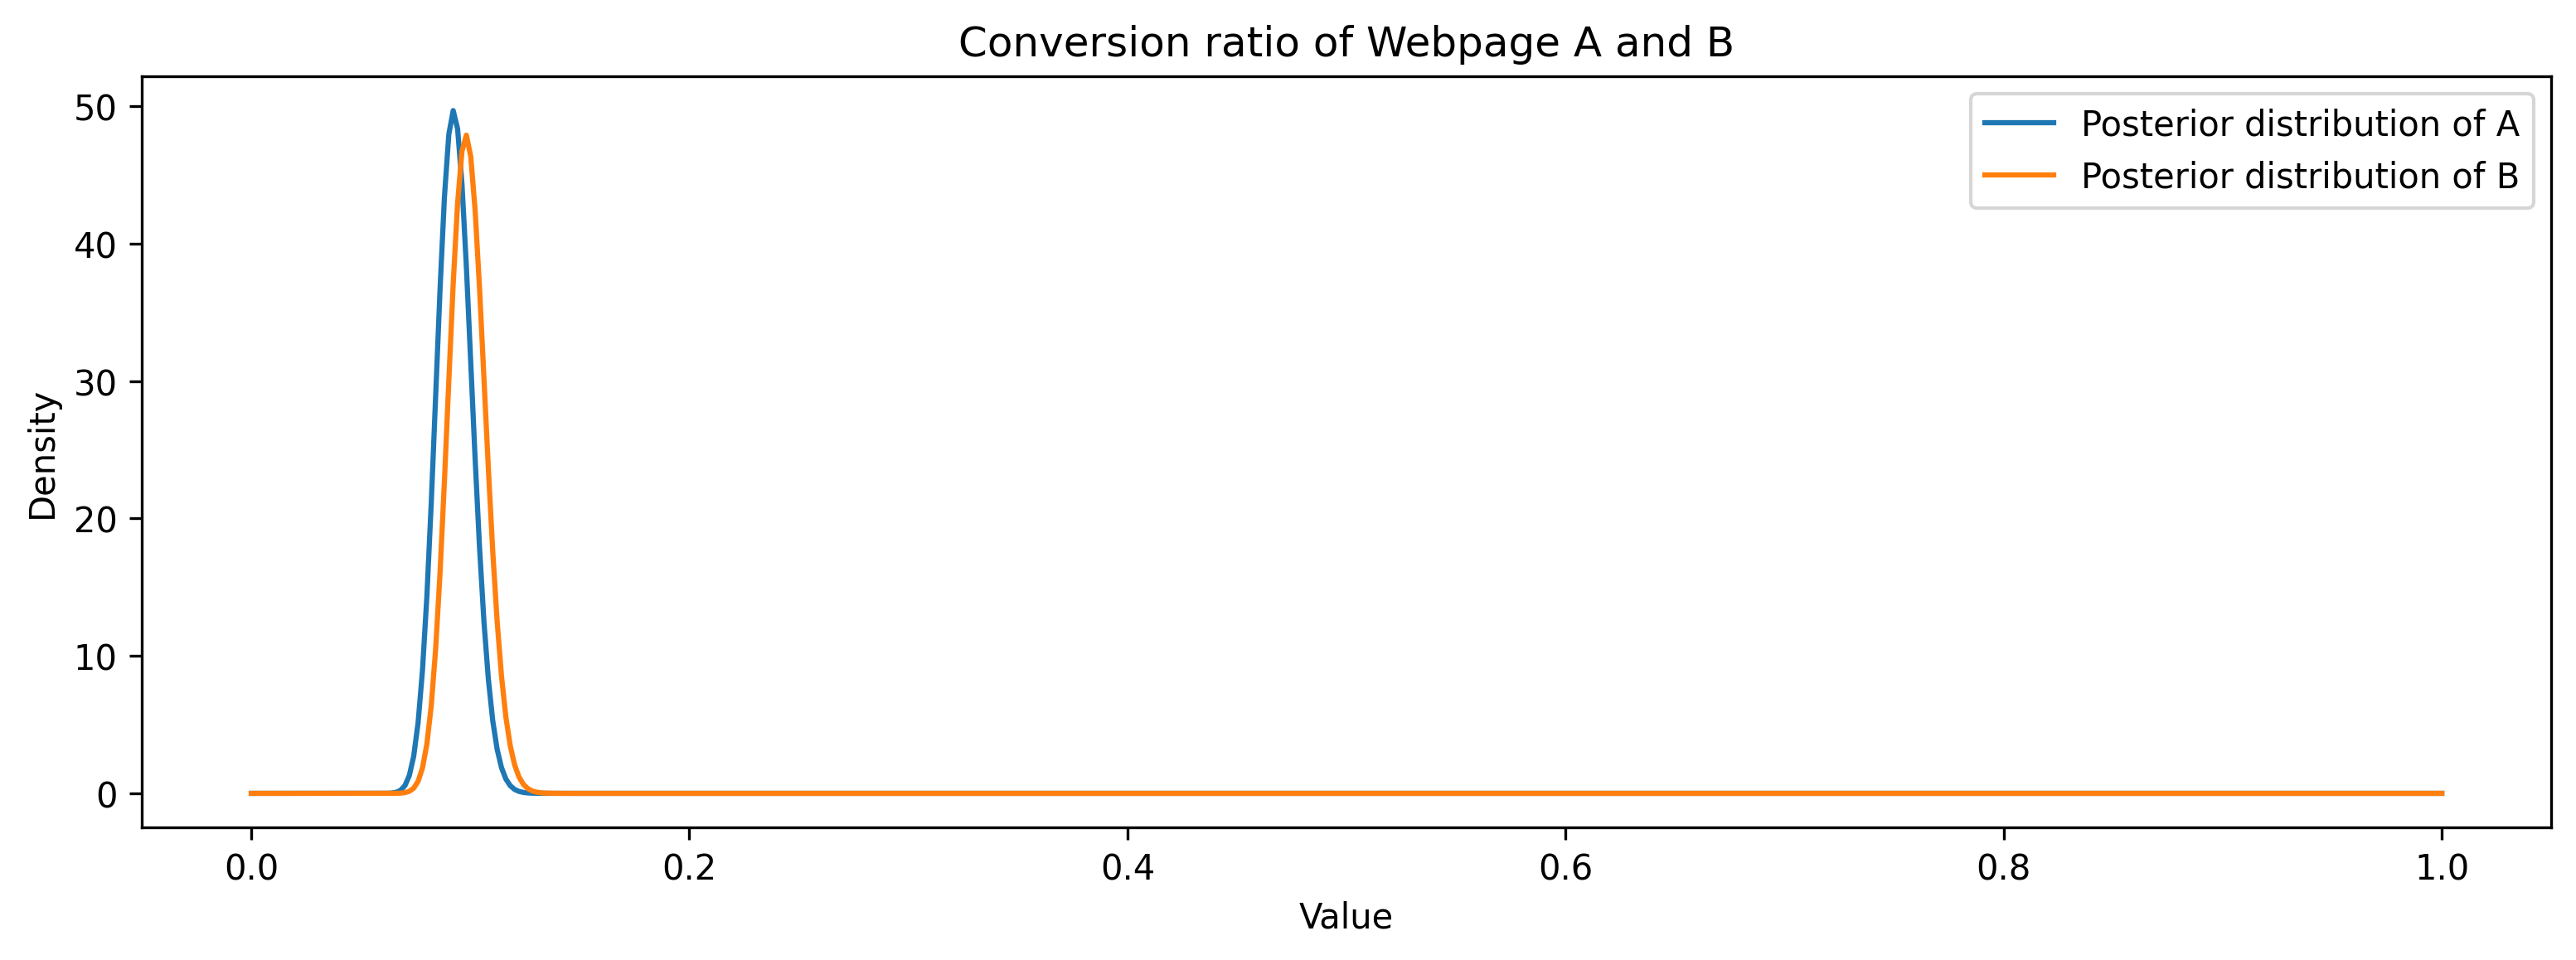

In [5]:
x = np.linspace(0,1, 500)
plt.plot(x, posterior_A.pdf(x), label='Posterior distribution of A')
plt.plot(x, posterior_B.pdf(x), label='Posterior distribution of B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Conversion ratio of Webpage A and B")
plt.legend();

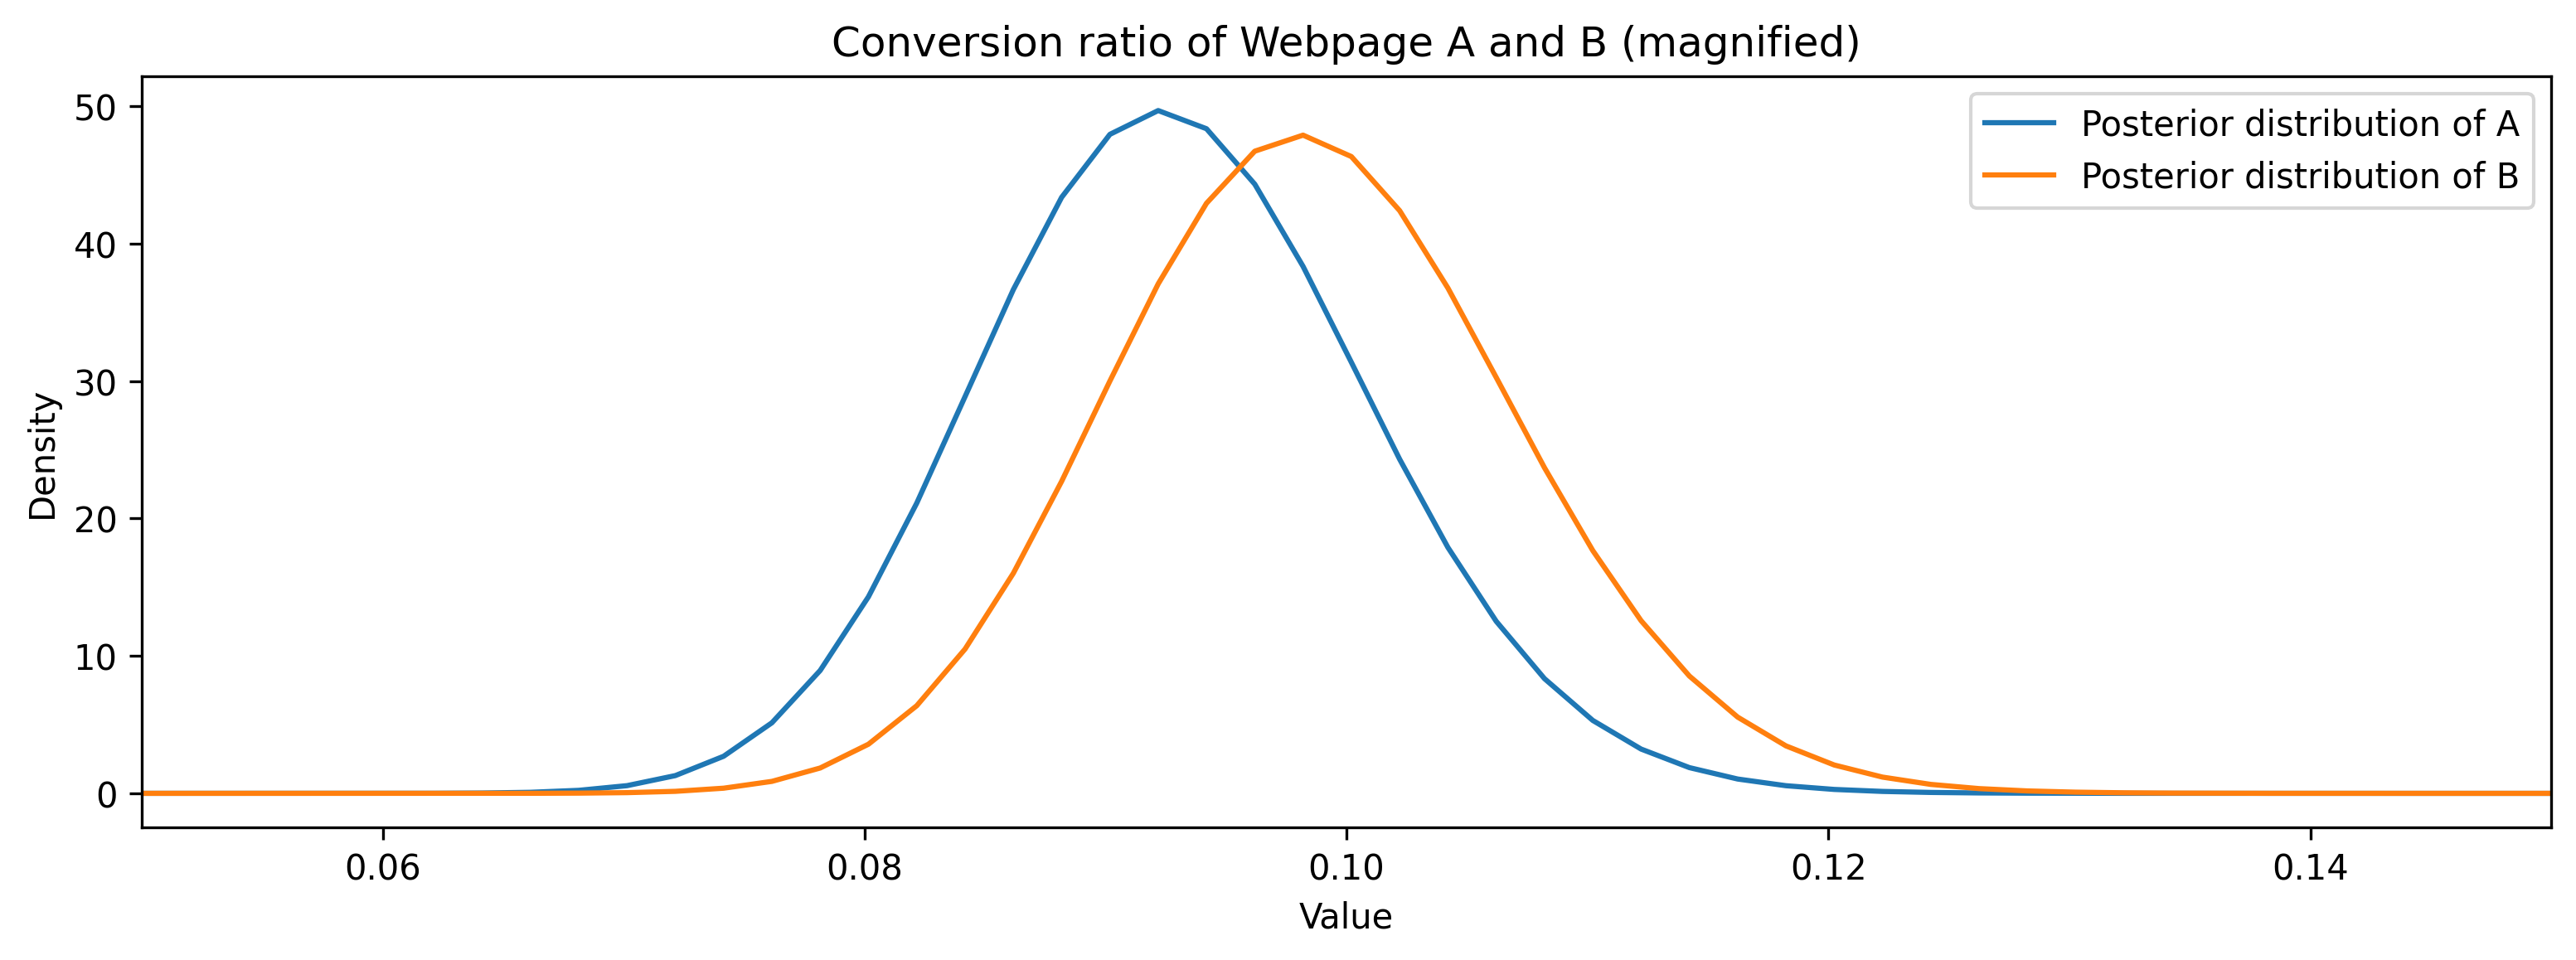

In [6]:
plt.plot(x, posterior_A.pdf(x), label='Posterior distribution of A')
plt.plot(x, posterior_B.pdf(x), label='Posterior distribution of B')
plt.xlim(0.05, 0.15)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Conversion ratio of Webpage A and B (magnified)")
plt.legend();

## 7.2 선형손실함수 추가하기

> 인터넷 기업의 공통된 목표는 가입자를 모으는 것뿐만 아니라 사용자가 선택할 수 있는 가입약정요금제를 최적화하는 것이다. 예를 들어 기업은 둘 이상의 선택지를 제시했을 때 고객이 높은 가격의 약정요금제를 선택하기를 원할 것이다.
사용자는 두 가지 다른 약정 페이지에 노출되어 있고, 우리는 이로부터 얻는 기대수익을 알고 싶다. 이전의 A/B 테스트 분석은 사용자의 가입 여부에만 관심을 두었다. 이제 우리는 얼마의 기대수익을 얻을 수 있는지도 알고 싶다.

### 7.2.1 기대수익분석

- 3가지 종류의 약정을 고려
    - 79요금
    - 49요금
    - 25요금 
    - 0요금 (약정 선택을 하지 않음)

- 각 요금제를 선택할 확률을 p79, p49, p25, p0이라고 하자. 
$$
p_{79} + p_{49} + p_{25} + p_0 = 1
$$

- 기대수익

$$
E[R] = 79p_{79} + 49p_{49} + 25p_{25} + 0p_0
$$

#### Multinomial-Dirichlet 모델 


In [15]:
from numpy.random import multinomial

P = [0.5, 0.2, 0.3]
N = 1
print(multinomial(N, P))

N = 10
print(multinomial(N, P))

[1 0 0]
[7 1 2]


In [16]:
from numpy.random import dirichlet
sample = dirichlet([1,1]) #[1,1]은 Beta(1,1)에 해당한다.
# 분포
print(sample)
print(sample.sum())

sample = dirichlet([1,1,1,1])
print(sample)
print(sample.sum())

[0.56181519 0.43818481]
1.0
[0.40545014 0.23941076 0.34543154 0.00970755]
1.0


- 1000명이 페이지를 보고 있을 때 그 중 10, 46, 80명이 각 79, 49, 25요금제를 선택했다고 하면 사후확률분포는 아래와 같다. 

In [17]:
N = 1000
N_79 = 10
N_49 = 46
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)

observations = np.array([N_79, N_49, N_25, N_0])

prior_parameters = np.array([1,1,1,1])

posterior_samples = dirichlet(prior_parameters + observations, # Posterior sample을 만드는 것, beta-binomial 관계 
    size=10000)

print ("사후확률분포에서 얻은 두 개의 랜덤 표본:")
print (posterior_samples[0])
print (posterior_samples[1])

사후확률분포에서 얻은 두 개의 랜덤 표본:
[0.0059341  0.05730703 0.08845841 0.84830046]
[0.01418865 0.04391749 0.07338408 0.86850978]


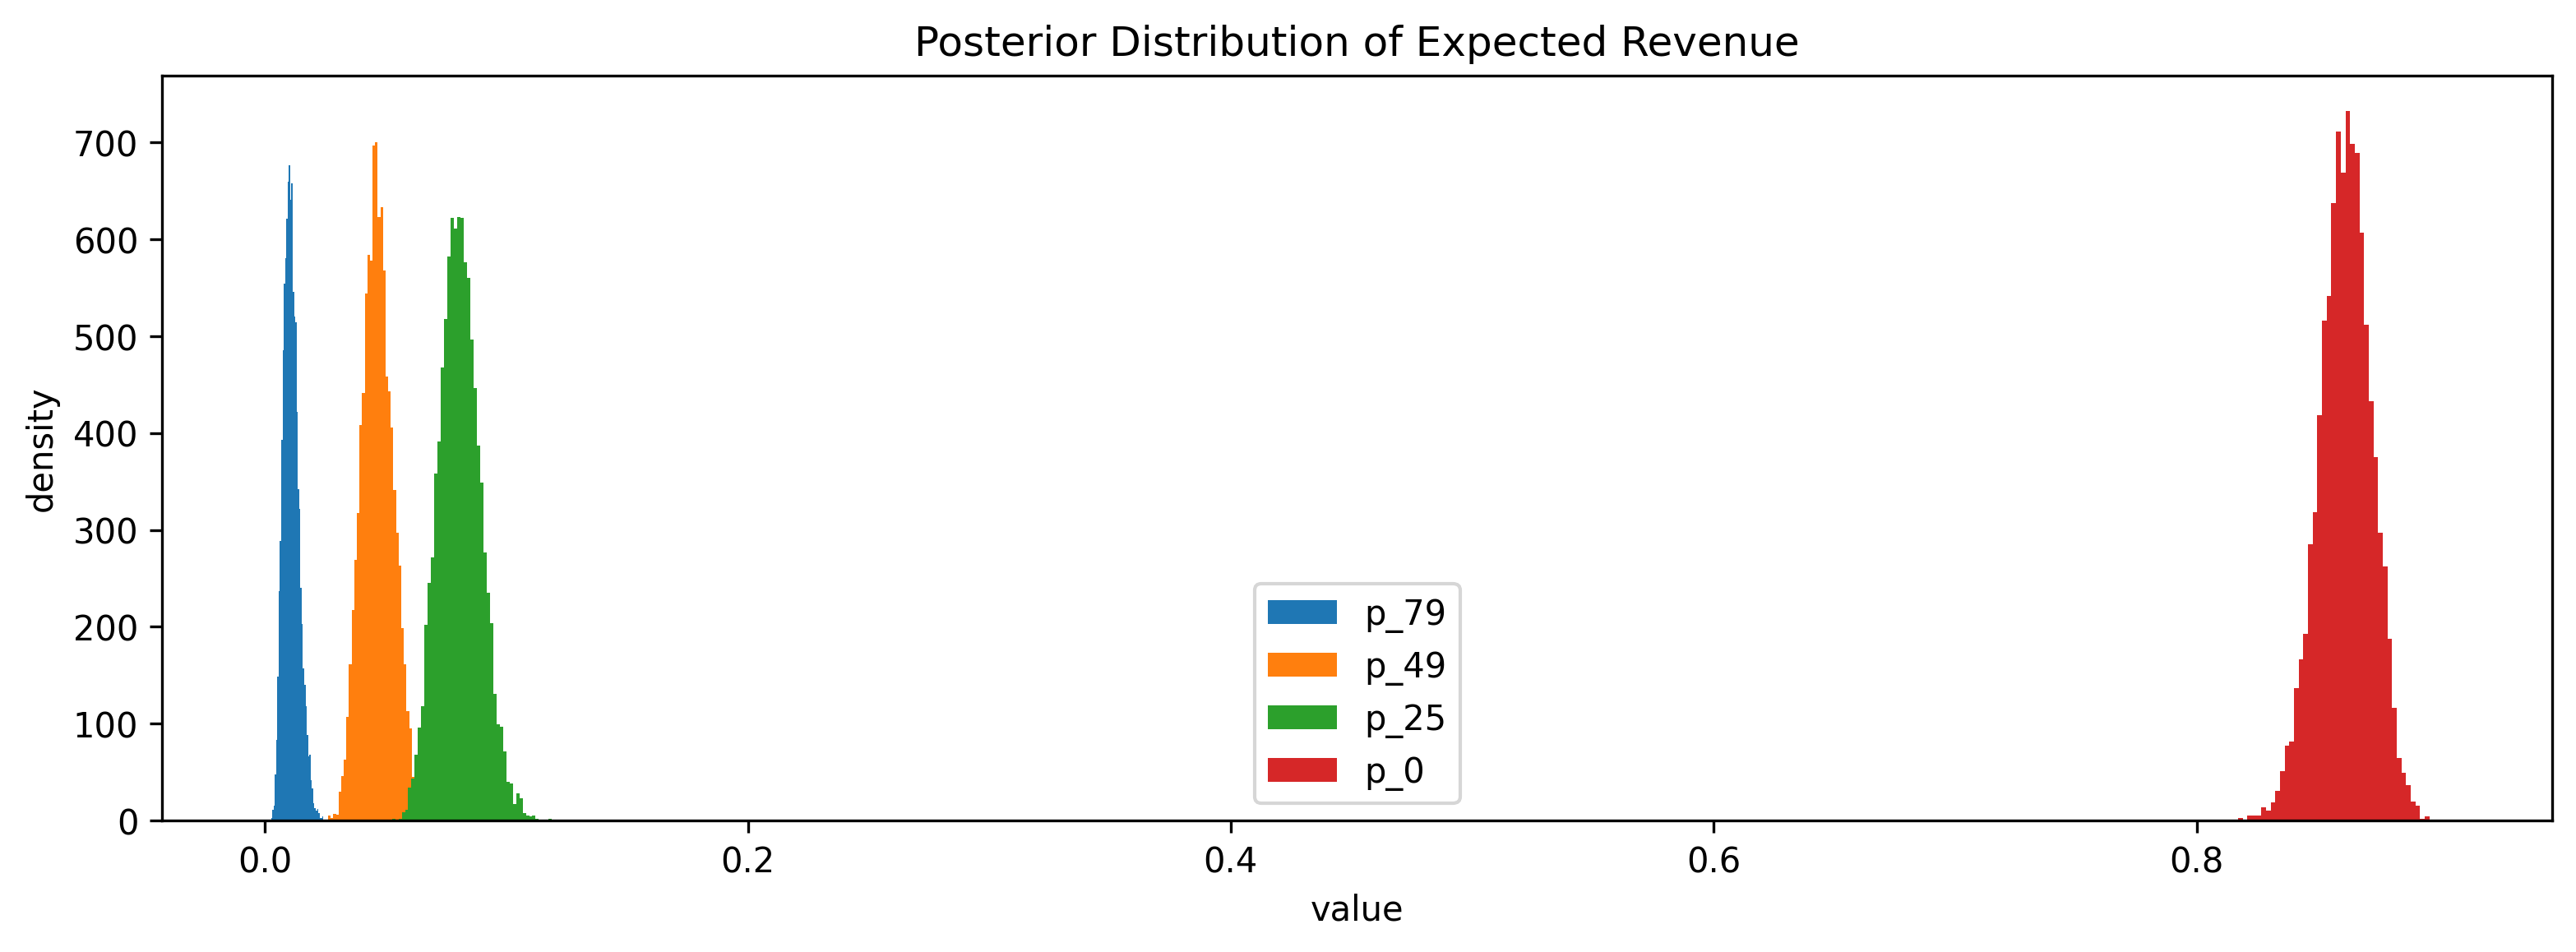

In [10]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50,
        label=label, histtype='stepfilled')
plt.xlabel('value')
plt.ylabel('density')
plt.title("Posterior Distribution of Expected Revenue")

plt.legend();

#### 기대수익의 고려 
 `expected_revenue()` 함수를 통해 디리클레 사후확률분포에서 얻은 각각의 표본을 매개변수로 넘겨 기댓값에 대한 사후확률분포를 계산

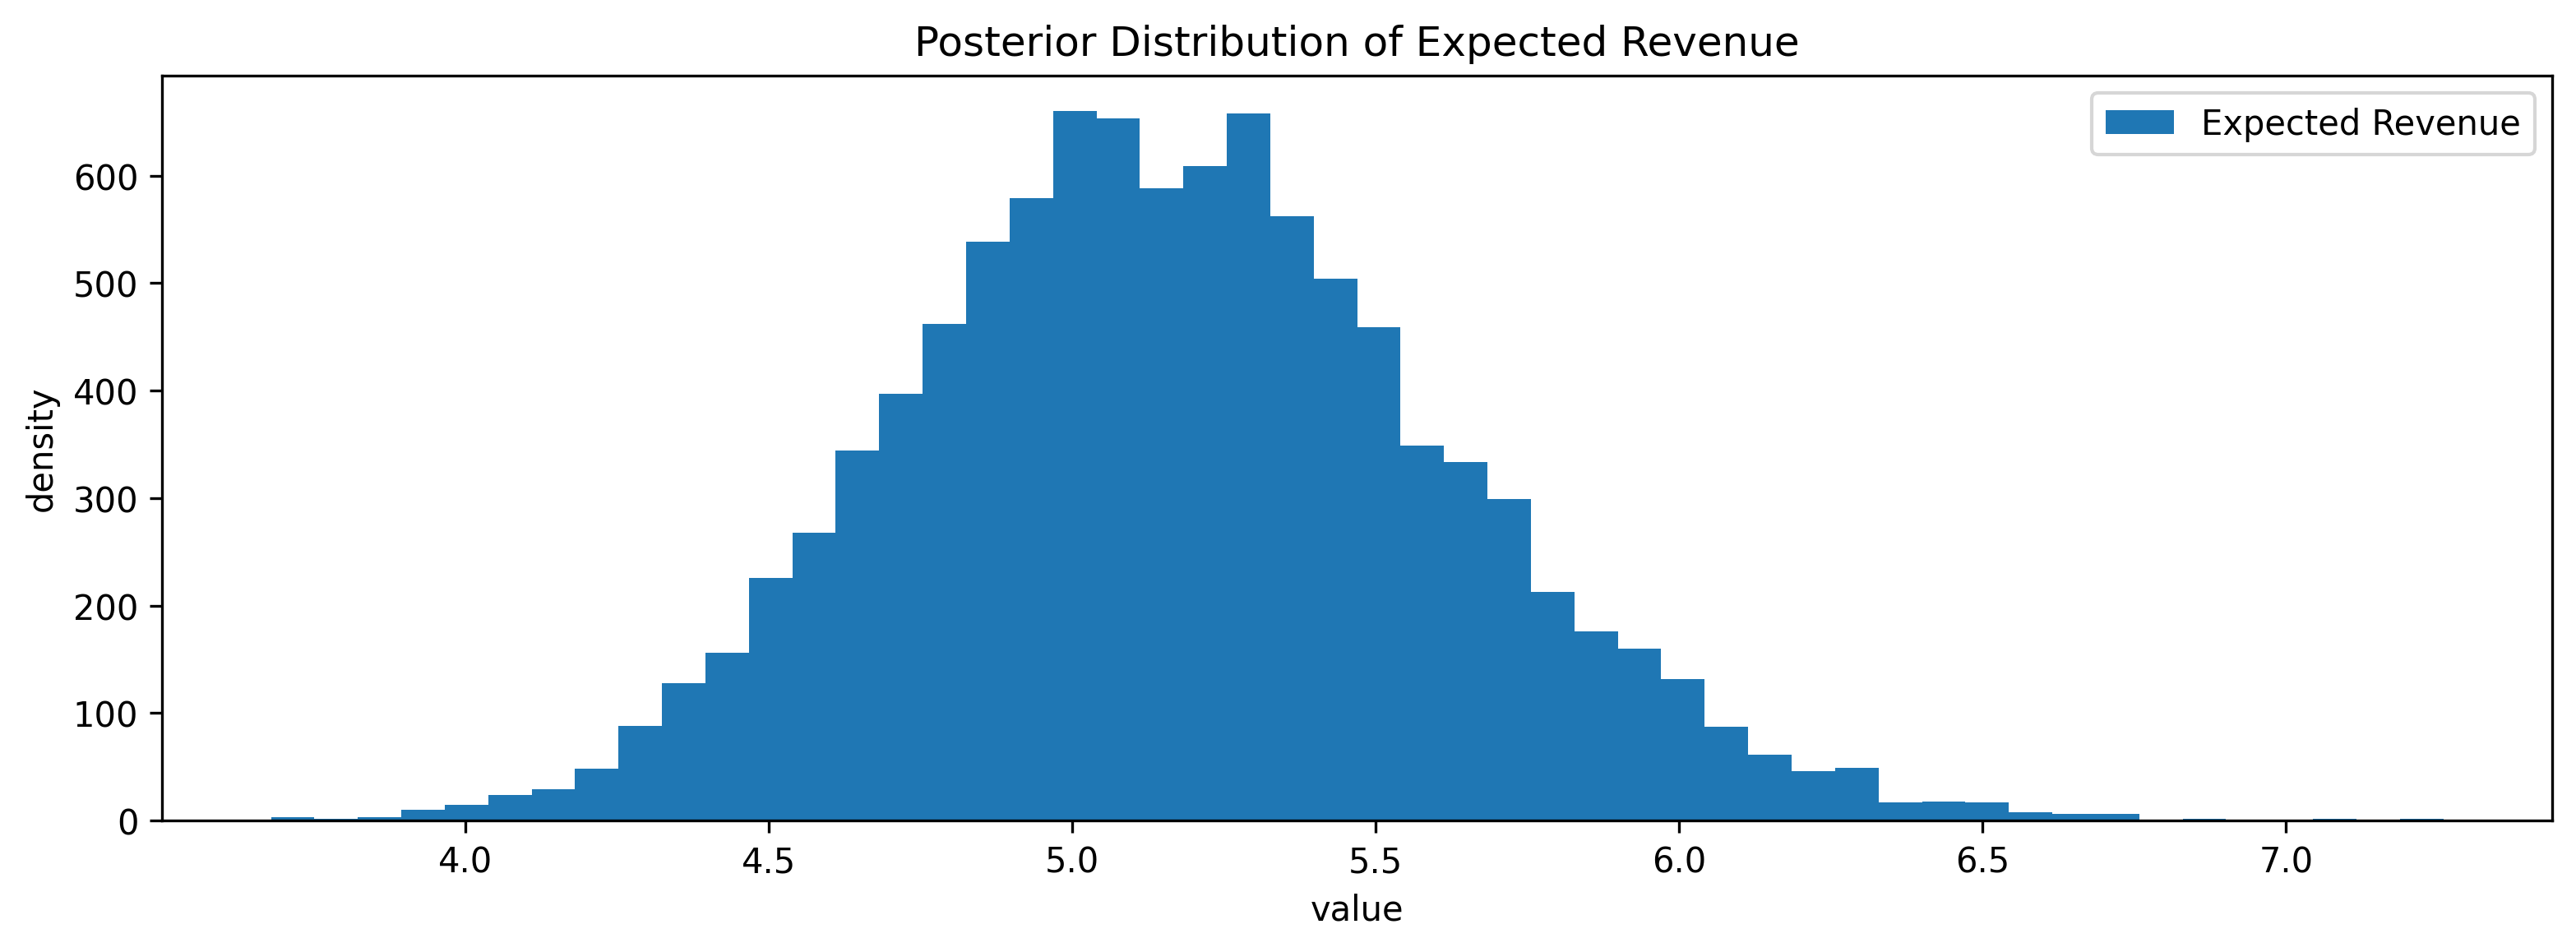

In [11]:
def expected_revenue(P):
    return 79*P[:,0] + 49*P[:,1] + 25*P[:,2] + 0*P[:,3]

# posterior_samples 의 shape가 (10000,4) 이기 때문에 4종류의 합 10000개로 구성된 그래프가 만들어진다.
posterior_expected_revenue = expected_revenue(posterior_samples)

plt.hist(posterior_expected_revenue, histtype='stepfilled',label='Expected Revenue', bins=50)
plt.xlabel('value')
plt.ylabel('density')
plt.title("Posterior Distribution of Expected Revenue")
plt.legend();

위의 그림을 통해 기대수익은 4~6 사이일 가능성이 있고, 이 범위를 벗어날 가능성은 없다는 걸 알 수 있다.

### 7.2.2 A/B 실험 확장하기

A 사이트와 B 사이트라는 두 가지 다른 웹페이지를 가지고 이 분석을 시도해보자. 이를 위해 인위적인 데이터를 만들었다.

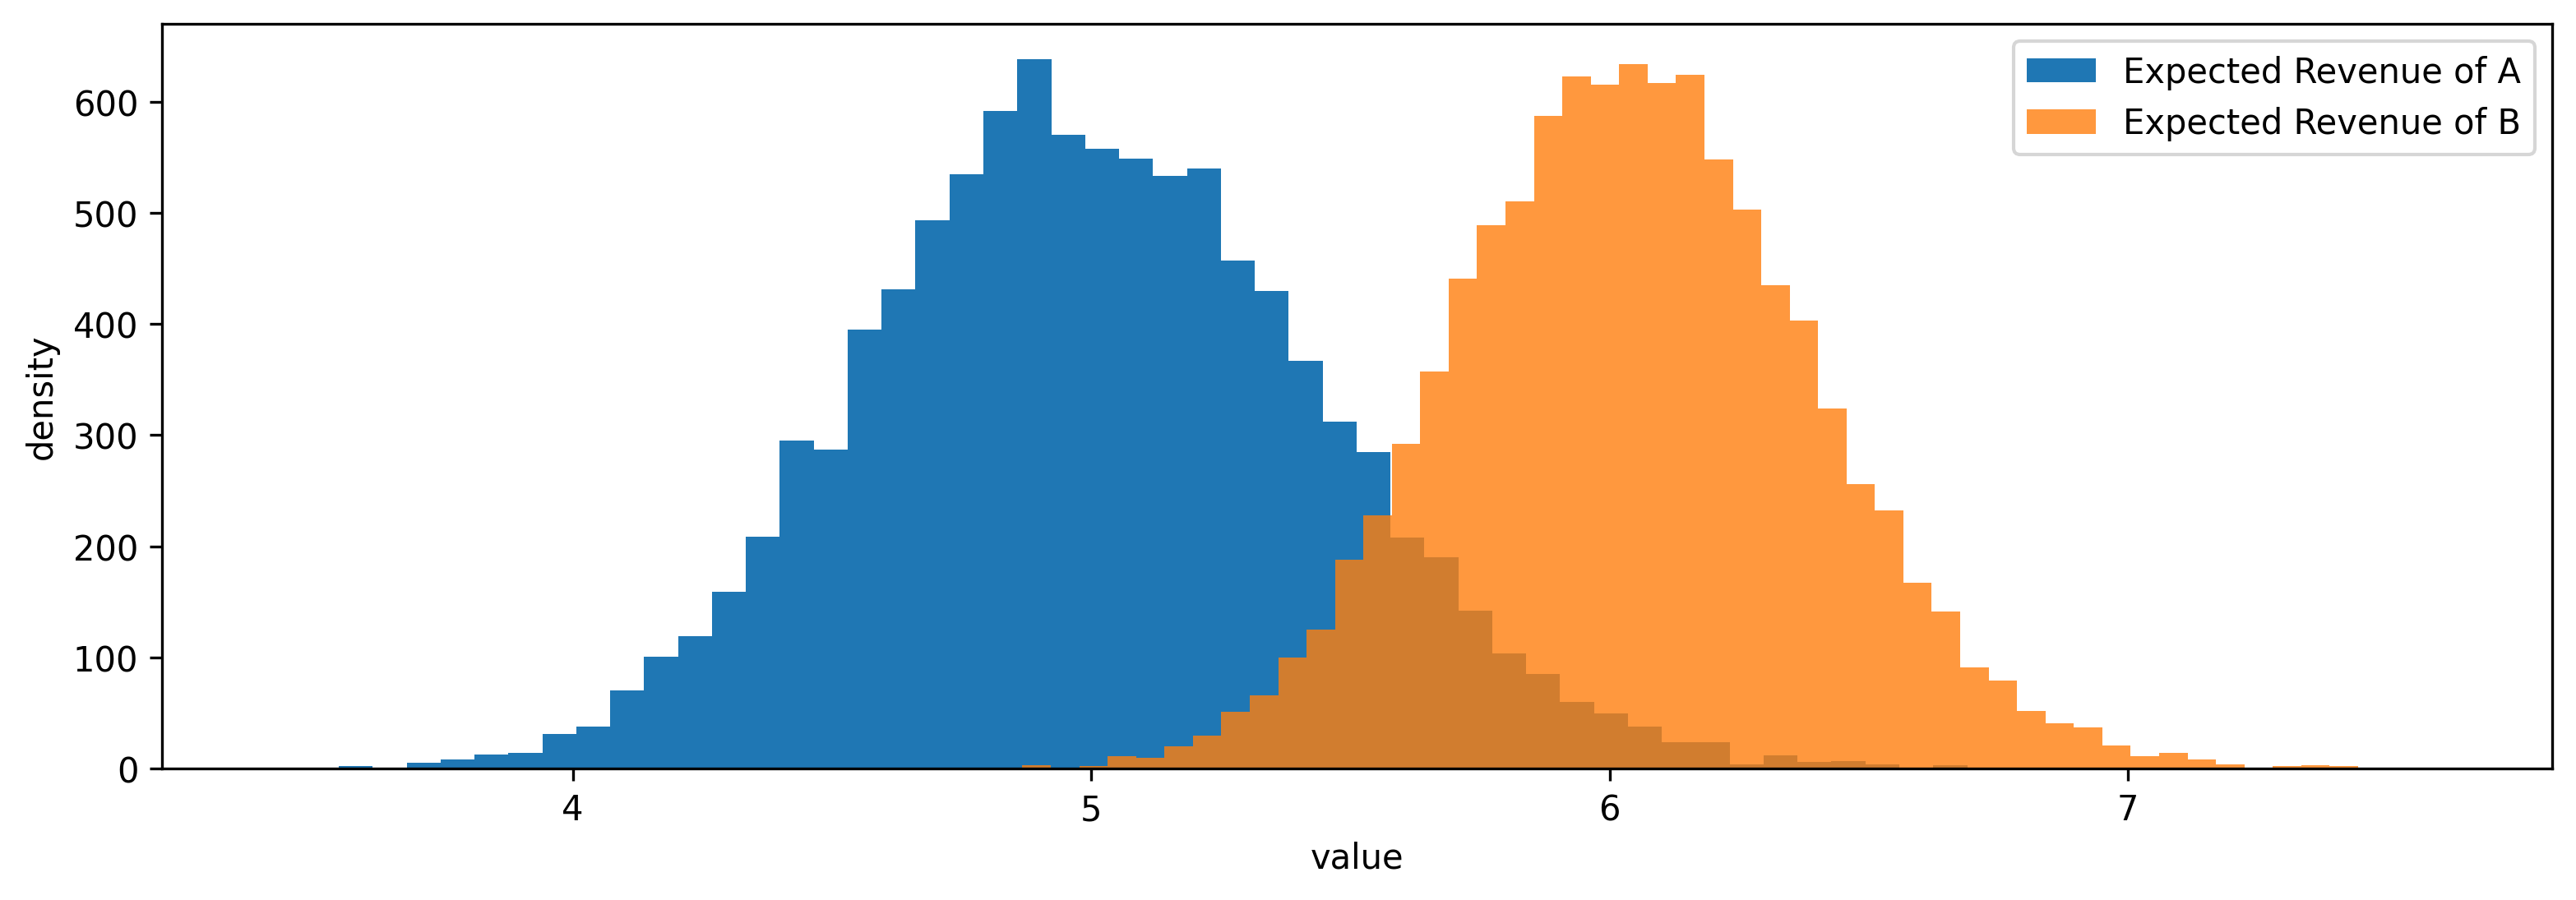

In [12]:
N_A = 1000 #1000명
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_49)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000 #2000명
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_49)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1,1,1,1])

posterior_samples_A = dirichlet(prior_parameters + observations_A, size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B, size=10000)


posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype='stepfilled',
    label='Expected Revenue of A', bins=50)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled',
    label='Expected Revenue of B', bins=50, alpha=0.8)
plt.xlabel('value')
plt.ylabel('density')
plt.legend();

In [13]:
p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print ("B 페이지가 A 페이지보다 수익이 클 확률: %.3f"%p)

B 페이지가 A 페이지보다 수익이 클 확률: 0.969


96%라는 값은 상당히 높은 값이므로 기업은 앞으로 B 페이지를 선택해야 한다. 



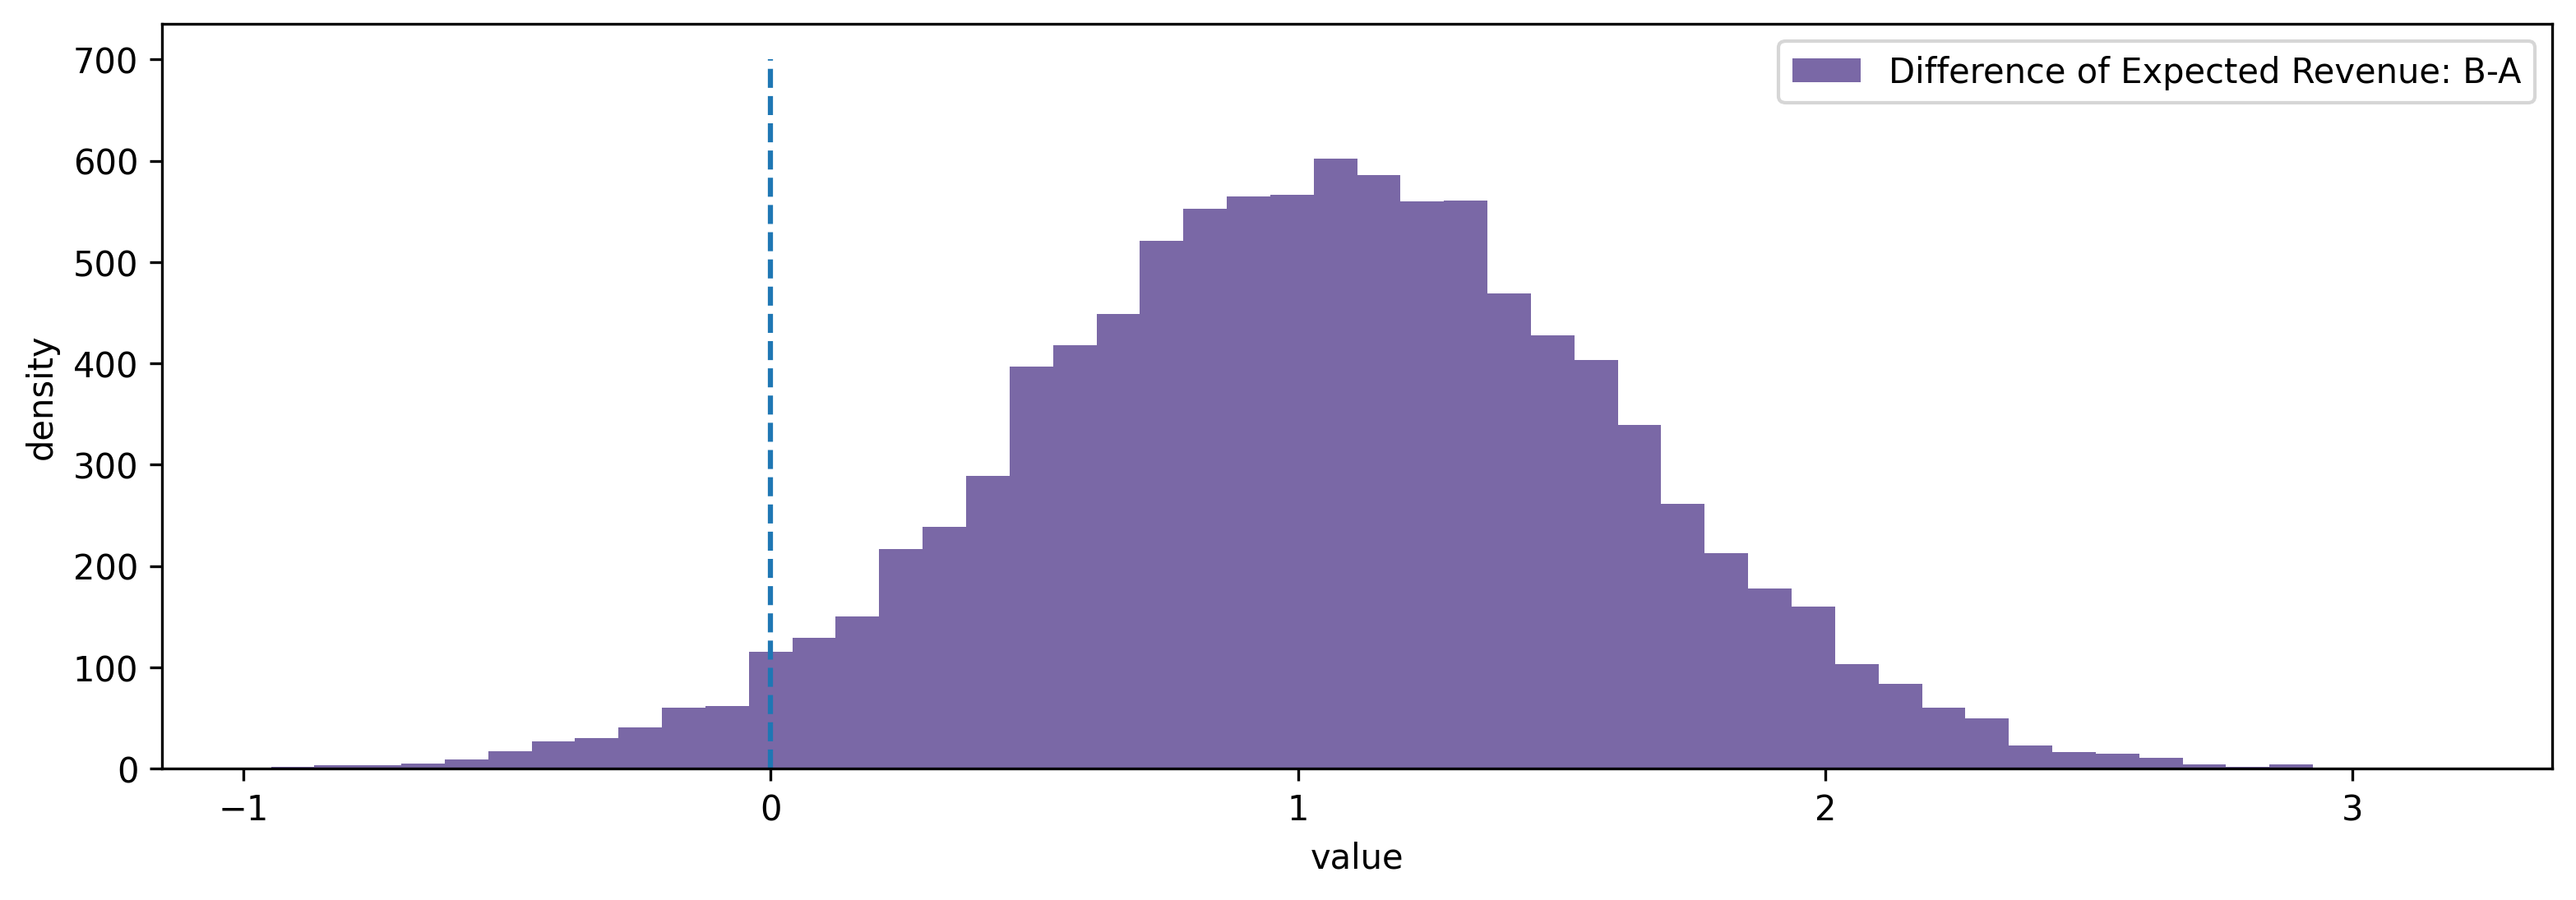

In [14]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6',
    label='Difference of Expected Revenue: B-A', bins=50)
plt.vlines(0, 0, 700, linestyles='--')
plt.xlabel('value')
plt.ylabel('density')
plt.legend();

이 사후확률분포를 보면 그 차이가 1 이상일 가능성이 50% 정도고, 심지어 2 이상일 수도 있음을 알 수 있다.